# Figure 2 Final

Notebook to make figure 2 for ms <br>
by Cascade Tuholske 2020.02.23

In [99]:
#### Depdencies 
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
from scipy.optimize import fmin
from scipy.stats import beta
from scipy.special import gamma as gammaf
import scipy
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures

In [2]:
#### Functions
def OLS(df, geog, col, alpha):
    
    """Finds linear coef for increase in stat by a given geography from 1983 - 2016, as well
    as the pct change in population of the cities within the given geography
    
    NOTE 2020.03.01 - This will throw a run time warning if all values of a col are zero (e.g. can regress
    a bunch of zeros) ... See note in run_OLD. CPT 
    
    NOTE 2020.03.01 - Later in the day this issue is resolved by removing the offending cities. See comments
    in code
    
    Args:
        df = HI stats dataframe
        geog = subset geography to calc people days regression
        col = col to regress on 
        alpha = ci alpha for coef
    """

    # Get results
    labels = []
    #delt_list = [] #CPT 2020.02.26
    #r2_list = [] #CPT 2020.02.26
    coef_list = []
    leftci_list = []
    rightci_list = []
    p_list = []
    df_out = pd.DataFrame()

    for label, df_geog in df.groupby(geog):

        # Get Data
        X_year = np.array(df_geog.groupby('year')['ID_HDC_G0'].mean().index).reshape((-1, 1))
        Y_stats = np.array(df_geog.groupby('year')[col].sum()).reshape((-1, 1))

        # Add Intercept
        X_year_2 = sm.add_constant(X_year)

        # Regress
        model = sm.OLS(Y_stats, X_year_2).fit() 
        
        # Get slope
        # first param in intercept coef, second is slope of line but if slope = 0, then intecept
        if len(model.params) == 2:
            coef = model.params[1]
            
        else:
            coef = model.params[0]
        
        # R2 and P
        #r2 = model.rsquared_adj #CPT 2020.02.26
        p = model.pvalues[0]

        # Pop change #CPT 2020.02.26
#         delt = df_geog.drop_duplicates('ID_HDC_G0').copy()
#         delt['delt_pop'] = delt['P2016'] - delt['P1983']
#         delt = delt['delt_pop'].sum()

        # GET Left and Right CI
        left_ci = model.conf_int(alpha=alpha)[1][0]
        right_ci = model.conf_int(alpha=alpha)[1][1]
        
        # Make lists
        labels.append(label)
        #r2_list.append(r2) #CPT 2020.02.26
        coef_list.append(coef)
        p_list.append(p)
        leftci_list.append(left_ci)
        rightci_list.append(right_ci)
        #delt_list.append(delt) #CPT 2020.02.26

    # Make data frame
    df_out[geog] = labels
    #df_out['p_delt'] = delt_list #CPT 2020.02.26
    #df_out['r2'] = r2_list #CPT 2020.02.26
    df_out['coef'] = coef_list
    df_out['p_value'] = [round(elem, 4) for elem in p_list]
    df_out['ci_left'] = leftci_list
    df_out['ci_right'] = rightci_list 

    return df_out


In [3]:
def run_OLS(stats, geog, alpha):
    """ Function calculate OLS coef of people days due to pop and heat and the 
    attribution index for distribution plots.
    
        
    NOTE 2020.03.01 - This will throw a run time warning if all values of a col are zero (e.g. can regress
    a bunch of zeros, now can we). This will happen if people_days, people_days_pop, people_days_heat or 
    total_days is zero for all years for a given city. This is still OK for our analysis. What is happening is
    that for some cities, the people-days due to heat is zero, meaning pday increases in only due to population. 
    
    
    This is because with the GHS-UCDB some city's population in 1983 is zero, which forces the pdays due to heat
    to be zero.
    
    NOTE 2020.03.01 - Later in the day this issue is resolved by removing the offending cities. See comments
    in code
    
    -- CPT  
    
    Args:
        stats = df to feed in
        geog = geography level to conduct analysis (city-level is 'ID-HDC-G0')
        alpha = alpha for CI coef   
    """
    # Get coef for people days
    out = OLS(stats, geog, 'people_days', alpha = alpha)
    out.rename(columns={"coef": "coef_pdays"}, inplace = True)
    out.rename(columns={"p_value": "p_value_pdays"}, inplace = True)
    out.rename(columns={"ci_left": "ci_left_pdays"}, inplace = True)
    out.rename(columns={"ci_right": "ci_right_pdays"}, inplace = True)
    
    # Get people days due to heat coef
    heat = OLS(stats, geog, 'people_days_heat', alpha = alpha) # get stats 
    heat.rename(columns={"coef": "coef_heat"}, inplace = True)
    heat.rename(columns={"p_value": "p_value_heat"}, inplace = True)
    heat.rename(columns={"ci_left": "ci_left_heat"}, inplace = True)
    heat.rename(columns={"ci_right": "ci_right_heat"}, inplace = True)
    out = out.merge(heat, on = geog, how = 'left') # merge
    
    # Get people days due to pop
    pop = OLS(stats, geog, 'people_days_pop', alpha = alpha) # get stats 
    pop.rename(columns={"coef": "coef_pop"}, inplace = True)
    pop.rename(columns={"p_value": "p_value_pop"}, inplace = True)
    pop.rename(columns={"ci_left": "ci_left_pop"}, inplace = True)
    pop.rename(columns={"ci_right": "ci_right_pop"}, inplace = True)
    out = out.merge(pop, on = geog, how = 'left') # merge
    
    # Get total days
    totDays = OLS(stats, geog, 'total_days', alpha = alpha) # get stats 
    totDays.rename(columns={"coef": "coef_totDays"}, inplace = True)
    totDays.rename(columns={"p_value": "p_value_totDays"}, inplace = True)
    totDays.rename(columns={"ci_left": "ci_left_totDays"}, inplace = True)
    totDays.rename(columns={"ci_right": "ci_right_totDays"}, inplace = True)
    out = out.merge(totDays, on = geog, how = 'left') # merge
    
    # attrib coef --- creates range -1 to 1 index of heat vs. population as a driver of total pdays increase
    out['coef_attrib'] = (out['coef_pop'] - out['coef_heat']) / (out['coef_pop'] + out['coef_heat']) # normalize dif
    
    # I am not sure if this works correcetly ... CPT 2020.02.27
    out['coef_attrib_left'] = (out['ci_left_pop'] - out['ci_left_heat']) / (out['ci_left_pop'] + out['ci_left_heat']) # normalize dif
    out['coef_attrib_right'] = (out['ci_right_pop'] - out['ci_right_heat']) / (out['ci_right_pop'] + out['ci_left_heat']) # normalize dif
    
    # drop all neg or zero pday slopes
    out = out[out['coef_pdays'] > 0]
    out = out[out['coef_heat'] > 0]
    out = out[out['coef_pop'] > 0]
    
    # normalize coef of attribution 
    norm = out['coef_attrib']
    out['coef_attrib_norm'] = (norm-min(norm))/(max(norm)-min(norm))
    norm = out['coef_attrib_left']
    out['coef_attrib_norm_left'] = (norm-min(norm))/(max(norm)-min(norm))
    norm = out['coef_attrib_right']
    out['coef_attrib_norm_right'] = (norm-min(norm))/(max(norm)-min(norm))
    
    return out

In [4]:
#### Load Data
# file path
DATA_IN = "/home/cascade/projects/UrbanHeat/data/"  # Note: Need ?dl=1 to make sure this file gets read correctly
FIG_OUT = "/home/cascade/projects/UrbanHeat/figures/"

# Raw Heat
FN_IN = 'processed/All_data_HI406_figdata.csv'
HI_STATS = pd.read_csv(DATA_IN+FN_IN)

# scale the date in the plot 
scale = 10**9 

print(HI_STATS.head(2))

# cols we want to add to HI_STATS
cols = ['region', 'intermediate-region', 'sub-region','CTR_MN_NM', 'ID_HDC_G0'] 

# open all the data
meta_fn = 'processed/All_data_HI406_meta.csv' # open all the data
all_data = pd.read_csv(DATA_IN+meta_fn)

# drop ID duplicates
meta = all_data.drop_duplicates('ID_HDC_G0')
meta = meta[cols]

HI_STATS = HI_STATS.merge(meta, on = 'ID_HDC_G0', how = 'inner')
print(HI_STATS.head(2))

   Unnamed: 0  ID_HDC_G0  year  total_days              P          P1983  \
0           0         22  1983           2   52064.452435   52064.452435   
1           1         26  1983           1  194088.886834  194088.886834   

           P2016  people_days  people_days_heat  people_days_pop  
0   73006.671133     0.000104          0.000104              0.0  
1  268055.635628     0.000194          0.000194              0.0  
   Unnamed: 0  ID_HDC_G0  year  total_days             P         P1983  \
0           0         22  1983           2  52064.452435  52064.452435   
1       10112         22  1984           1  53373.163358  52064.452435   

          P2016  people_days  people_days_heat  people_days_pop    region  \
0  73006.671133     0.000104          0.000104         0.000000  Americas   
1  73006.671133     0.000053          0.000052         0.000001  Americas   

  intermediate-region        sub-region      CTR_MN_NM  
0    Northern America  Northern America  United States  
1

In [5]:
#### Drop 40 cities where P1983 == 40
print(len(HI_STATS))
HI_STATS = HI_STATS[HI_STATS['P1983'] > 0]
print(len(HI_STATS))

#### Drop cities with only one Tmax Day in 1983 and none else because you cannot regress them
drop_list = [2543, 2560, 3667, 3669, 6122, 6156] # city IDS
HI_STATS= HI_STATS[~HI_STATS['ID_HDC_G0'].isin(drop_list)]
print(len(HI_STATS))

392972
391612
391408


In [6]:
#### Chunk Data for plots -- see functions for warnings explained 

# Get Populations
df_years = HI_STATS[['ID_HDC_G0', 'P1983', 'P2016']]
df_years = df_years.drop_duplicates('ID_HDC_G0')

# Global
# plotdata = run_OLS(HI_STATS, 'ID_HDC_G0', alpha = 0.05)

# Chunk 1
geog1 = 'region'
loc1 = 'Europe'
chunk1 = HI_STATS[HI_STATS[geog1] == loc1]
plotdata1 = run_OLS(chunk1, 'ID_HDC_G0', alpha = 0.05)
plotdata1 = plotdata1.merge(df_years, on = 'ID_HDC_G0', how = 'left')

# Chunk 2
geog2 = 'sub-region'
loc2 = 'Eastern Asia'
chunk2 = HI_STATS[HI_STATS[geog2] == loc2]
plotdata2 = run_OLS(chunk2, 'ID_HDC_G0', alpha = 0.05)
plotdata2 = plotdata2.merge(df_years, on = 'ID_HDC_G0', how = 'left')


# Chunk 3
geog3 = 'sub-region'
loc3 = 'Western Asia'
chunk3 = HI_STATS[HI_STATS[geog3] == loc3]
plotdata3 = run_OLS(chunk3, 'ID_HDC_G0', alpha = 0.05)
plotdata3 = plotdata3.merge(df_years, on = 'ID_HDC_G0', how = 'left')

# Chunk 4
geog4 = 'sub-region'
loc4 = 'Sub-Saharan Africa'
chunk4 = HI_STATS[HI_STATS[geog4] == loc4]
plotdata4 = run_OLS(chunk4, 'ID_HDC_G0', alpha = 0.05)
plotdata4 = plotdata4.merge(df_years, on = 'ID_HDC_G0', how = 'left')


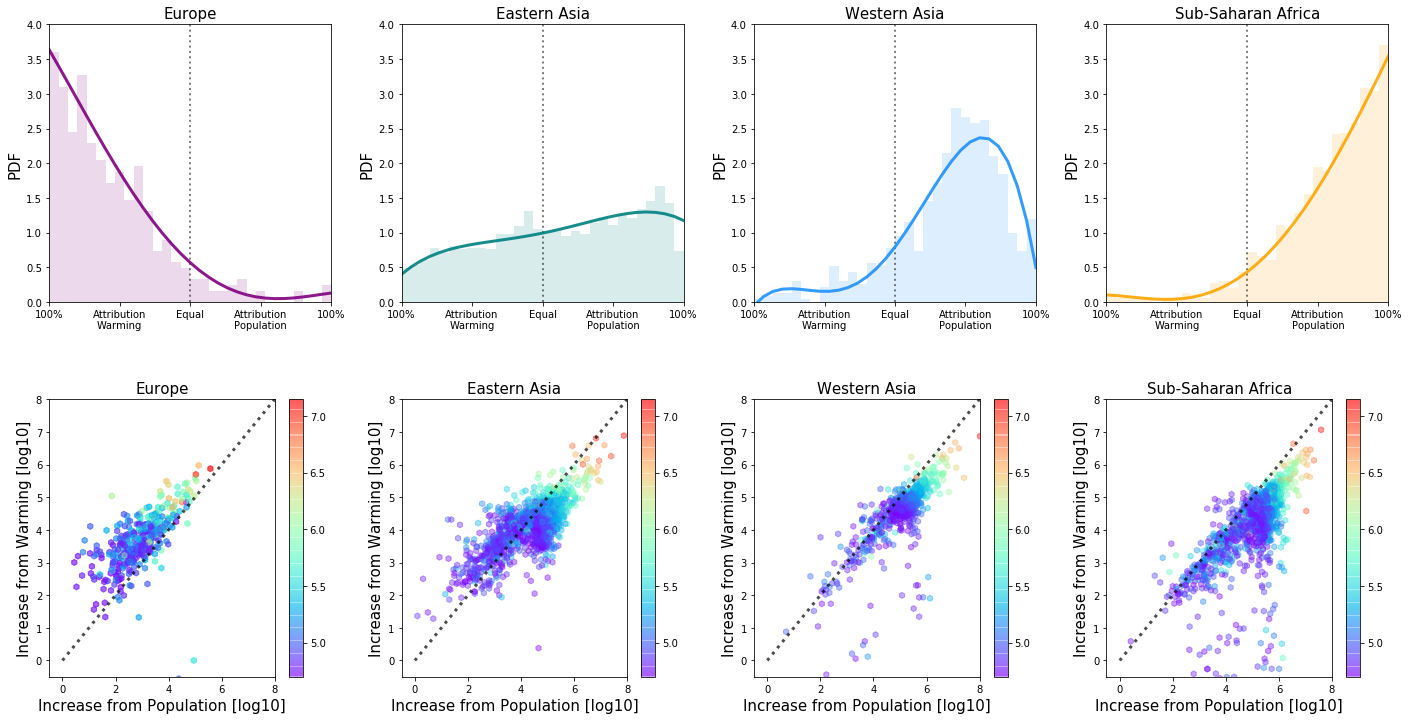

In [166]:
#### Fig 2 Plot

# Chunks in a list & colors
df_list = [plotdata1 , plotdata2 , plotdata3 , plotdata4, plotdata1 , plotdata2 , plotdata3 , plotdata4]
color_list = ['purple', 'teal', 'dodgerblue', 'orange', 'purple', 'teal', 'dodgerblue', 'orange']
loc_list = [loc1, loc2, loc3, loc4, loc1, loc2, loc3, loc4]

# Size
fig, axs = plt.subplots(2, 4, figsize = (24, 12), sharex=False, sharey = False)
axs = axs.ravel()
fig.subplots_adjust(wspace= 0.25, hspace = 0.35)
fig = plt.gcf()

# Plot args
kwargs = {'lw': 3, 'alpha' : 0.9, 'linestyle' : '-'} # ked line kwargs

for i, df in enumerate(zip(df_list, color_list)):
    
    # First row
    if i < 4:
        xlim = [0,1]
        ylim = [0,4]
        ticks = [0, .25, .5, .75, 1]
        #labels = [str(100), 50, 0, 50, str(100)]#[100, 80, 60, 40, 20, 0, 20, 40, 60, 80, 100]
        labels = ['100%','Attribution\nWarming', 'Equal', 'Attribution\nPopulation', '100%']
        
        # Git data for hist and poly fit 
        data = df[0]['coef_attrib_norm'] 
        axs[i].hist(data, density = True, color = df[1], alpha = 0.15, bins = 30) 
        x = axs[i].hist(data, density = True, color = df[1], alpha = 0, bins = 30)[1]
        y = axs[i].hist(data, density = True, color = df[1], alpha = 0, bins = 30)[0]
        y = np.insert(y, 0, y[0])
        
        # Poly fit plot
        x = x[:, np.newaxis]
        y = y[:, np.newaxis]
        polynomial_features= PolynomialFeatures(degree=4)
        x_poly = polynomial_features.fit_transform(x)
        model = LinearRegression()
        model.fit(x_poly, y)
        y_poly_pred = model.predict(x_poly)
        sort_axis = operator.itemgetter(0)
        sorted_zip = sorted(zip(x,y_poly_pred), key=sort_axis)
        x, y_poly_pred = zip(*sorted_zip)
        axs[i].plot(x, y_poly_pred, alpha = 0.9, linewidth=3, color = color_list[i])
        
        # V line 
        axs[i].vlines(x = 0.5, ymin = 0, ymax = 5, lw=2, linestyles = ':', 
                      alpha = 0.5, color = 'black')
        
        #sns.kdeplot(data, color = df[1], ax = axs[i], **kwargs, legend = False) # kernel
        axs[i].set_title(loc_list[i], fontsize = 15) 
        axs[i].set_xlim(xlim)
        axs[i].set_ylim(ylim)
        axs[i].set_ylabel('PDF', fontsize = 15)
        #axs[i].set_xlabel('% Warming                 % Population', fontsize = 15)
        axs[i].set_xticks(ticks);
        axs[i].set_xticklabels(labels)
    
    # Second row
    if i >= 4:
        lim = 8
        
        X = np.log10(df[0]['coef_pop']*scale)
        Y = np.log10(df[0]['coef_heat']*scale)
        C = np.log10(df[0]['P2016']) ##########<<<< CASCADE FIX SO WE CAN CITY

        # plots
        im  = axs[i].scatter(X, Y, alpha = 0.4, marker = 'h', c = C, cmap = 'rainbow')

        # Make one-to-one-line
        axs[i].plot([0, lim], [0, lim], ':', lw=3, alpha = 0.7, color = 'black')
        axs[i].set_title(loc_list[i], fontsize = 15)
        
        if i == 4:
            cmap = axs[i].scatter(X, Y, alpha = 0.4, marker = 'h', c = C, cmap = 'rainbow')

        fig.colorbar(ax = axs[i],  mappable = cmap)

        # Set limits
        axs[i].set_xlim([-0.5, lim])
        axs[i].set_ylim([-0.5, lim])
        
        axs[i].set_ylabel('Increase from Warming [log10]', fontsize = 15)
        axs[i].set_xlabel('Increase from Population [log10]', fontsize = 15)


# Set the ticks and ticklabels for all axes
#plt.setp(axs, xticks=ticks, xticklabels=labels);

## Labels 
# plt.xlabel('Coef of Attribtuion (Right is people, left heat)', fontsize = 15, labelpad = 10)
# plt.ylabel('PDF', fontsize = 15)
# fig.title('Dist of PeopleDays Attribution Coef, 1983 - 2016', fontsize = 15)

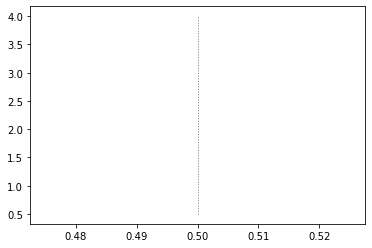

In [152]:
plt.plot([.5, .5], [.5, 4], ':', lw=1, alpha = 0.5, color = 'black')


In [ ]:
check = HI_STATS.drop_duplicates('ID_HDC_G0')

In [ ]:
len(check[check['P1983'] == 0])

# Try poly fit

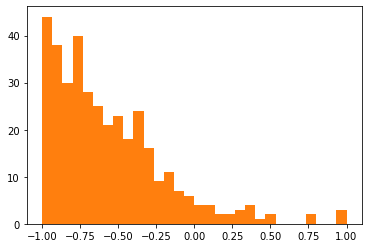

In [97]:
data = plotdata1
title = loc1
Y = plt.hist(data['coef_attrib'], bins = 30)[0]
X = plt.hist(data['coef_attrib'], bins = 30)[1]
Y = np.insert(Y, 0, Y[0])

2.582660710798541
0.9670318313554214


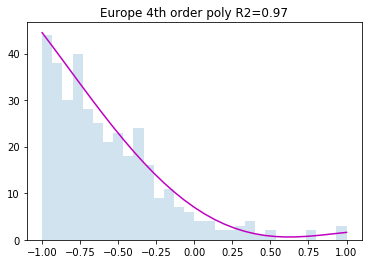

In [98]:
import operator

import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures

np.random.seed(0)
x = X
y = Y

# transforming the data to include another axis
x = x[:, np.newaxis]
y = y[:, np.newaxis]

polynomial_features= PolynomialFeatures(degree=4)
x_poly = polynomial_features.fit_transform(x)

model = LinearRegression()
model.fit(x_poly, y)
y_poly_pred = model.predict(x_poly)

rmse = np.sqrt(mean_squared_error(y,y_poly_pred))
r2 = r2_score(y,y_poly_pred)
print(rmse)
print(r2)

plt.hist(data['coef_attrib'], bins = 30, alpha = .2)
# sort the values of x before line plot
sort_axis = operator.itemgetter(0)
sorted_zip = sorted(zip(x,y_poly_pred), key=sort_axis)
x, y_poly_pred = zip(*sorted_zip)
plt.plot(x, y_poly_pred, color='m')
plt.title(title+' 4th order poly R2='+str(round(r2,2)))
plt.show()

In [44]:
trend

array([27.83846698, 21.88856989])